In [1]:
%matplotlib inline
from lynxes.model import DeployedModel
from lynxes.model import InMemoryModel
from lynxes.core.explanations import Interpretation
import pandas as pd
import numpy as np
import json
import requests
np.random.seed(1)
from __future__ import print_function

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def input_formatter(data):
    # Convert a data frame of the format 
    #     Status.of.existing.checking.account  Duration.in.month Credit.history Savings.account.bonds 
    # 0                                 A11                  6            A34            A65
    # 1                                 A12                 48            A32            A61 
    # to the following format:
    # {"input":[{"Status.of.existing.checking.account": "A11", "Duration.in.month": 24, "Credit.history": "A32", 
    # "Savings.account.bonds": "A63"}, {"Status.of.existing.checking.account": "A12", "Duration.in.month": 23, 
    # "Credit.history": "A31", "Savings.account.bonds": "A65"}, {"Status.of.existing.checking.account": "A12", 
    # "Duration.in.month": 23, "Credit.history": "A31", "Savings.account.bonds": "A65"}]}
    #if not isinstance(data, pd.DataFrame):
    #        raise TypeError("must be a dataframe")
    return {"input": pd.DataFrame(data).to_json(orient='records')}
    
def output_formatter(response, key='probability'):
    return np.array(response.json()['probability'])

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
feature_name = ['Status of existing checking account', 'Duration in month', 'Credit history'
, 'Purpose', 'Credit amount', 'Savings account.bonds', 'Employment years'
, 'Installment rate in percentage of disposable income'
, 'Personal status and sex', 'Other debtors.guarantors', 'Present residence since'
, 'Property', 'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank'
, 'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 'Status']

f_n = [f.replace(' ', '.') for f in feature_name]
input_data = pd.read_csv(url, sep=' ', names=f_n)
input_data.head(1)

,Status.of.existing.checking.account,Duration.in.month,Credit.history,Purpose,Credit.amount,Savings.account.bonds,Employment.years,Installment.rate.in.percentage.of.disposable.income,Personal.status.and.sex,Other.debtors.guarantors,...,Property,Age.in.years,Other.installment.plans,Housing,Number.of.existing.credits.at.this.bank,Job,Number.of.people.being.liable.to.provide.maintenance.for,Telephone,Foreign.worker,Status
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1


In [4]:
deployed_model_uri = "http://datsci.dev:8000/predict"

In [5]:
# Filter on the features as needed by the model
selected_input_data = input_data[['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 
                                  'Savings.account.bonds']]
#print(type(selected_input_data.values))
print(selected_input_data.head(2))
#input_formatter(selected_input_data.values)
print(type(selected_input_data))

  Status.of.existing.checking.account  Duration.in.month Credit.history  \
0                                 A11                  6            A34   
1                                 A12                 48            A32   

  Savings.account.bonds  
0                   A65  
1                   A61  
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Convert the dataframe to the following the required format:
input_data = input_formatter(selected_input_data.head(5))
print(input_data['input'])

[{"Status.of.existing.checking.account":"A11","Duration.in.month":6,"Credit.history":"A34","Savings.account.bonds":"A65"},{"Status.of.existing.checking.account":"A12","Duration.in.month":48,"Credit.history":"A32","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A14","Duration.in.month":12,"Credit.history":"A34","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A11","Duration.in.month":42,"Credit.history":"A32","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A11","Duration.in.month":24,"Credit.history":"A33","Savings.account.bonds":"A61"}]


In [7]:
dep_model = DeployedModel(deployed_model_uri,
                         input_formatter,
                         output_formatter,
                         examples=selected_input_data.head(5))

2017-05-02 23:27:36,433 - lynxes.core.explanations - INFO - Loading Data
2017-05-02 23:27:36,435 - lynxes.data.dataset - DEBUG - __init__ data.shape: (5, 4)
2017-05-02 23:27:36,435 - lynxes.data.dataset - DEBUG - after transform data.shape: (5, 4)
2017-05-02 23:27:36,440 - lynxes.core.explanations - INFO - Data loaded
2017-05-02 23:27:36,440 - lynxes.core.explanations - DEBUG - Data shape: (5, 4)
2017-05-02 23:27:36,441 - lynxes.core.explanations - DEBUG - Dataset Feature_ids: ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds']
2017-05-02 23:27:36,446 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 3)]
2017-05-02 23:27:36,447 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (1, 3)
2017-05-02 23:27:36,447 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 10
2017-05-02 23:27:36,448 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 500, 'replace': True, 'sample':

[[<matplotlib.figure.Figure at 0x7f87450f0d10>,

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


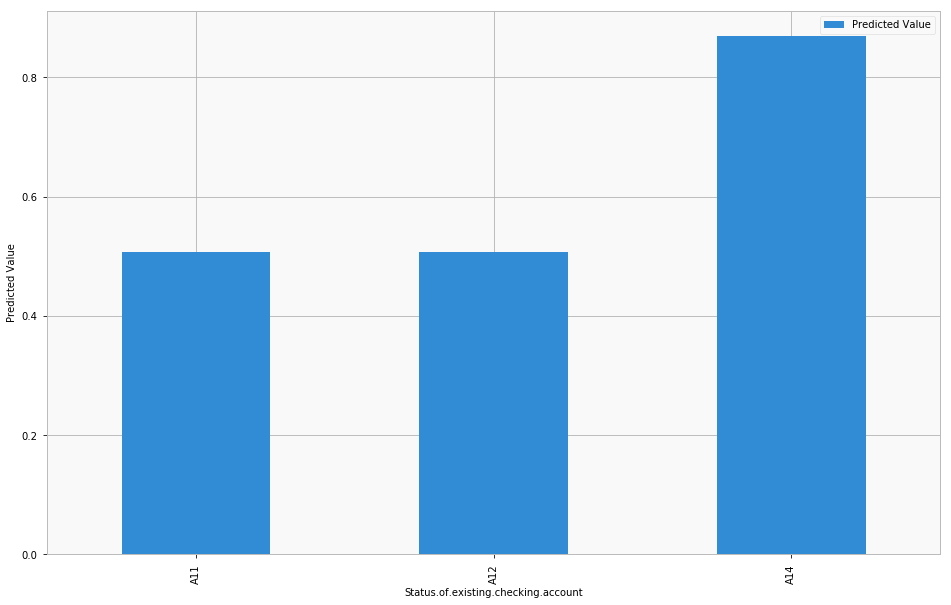

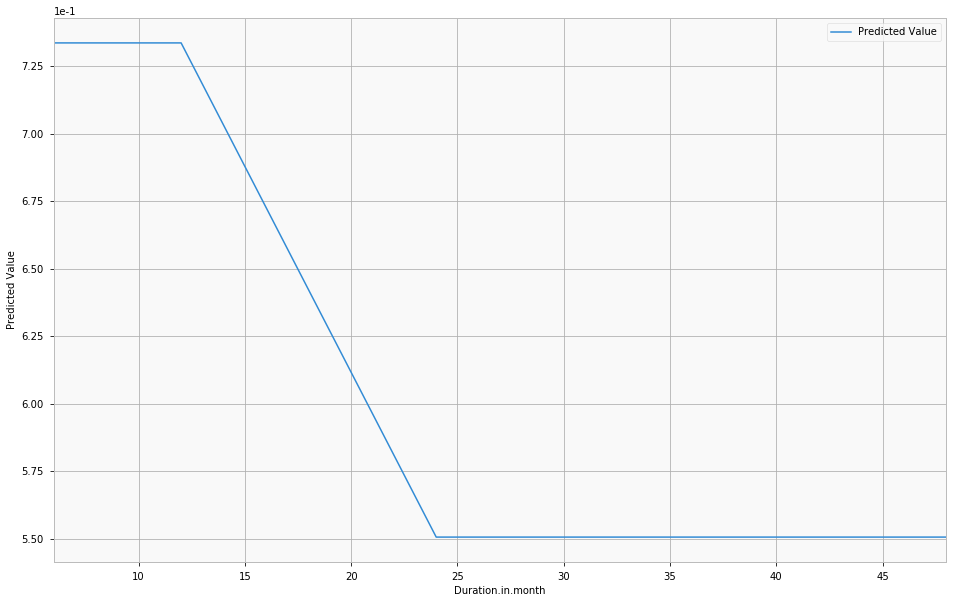

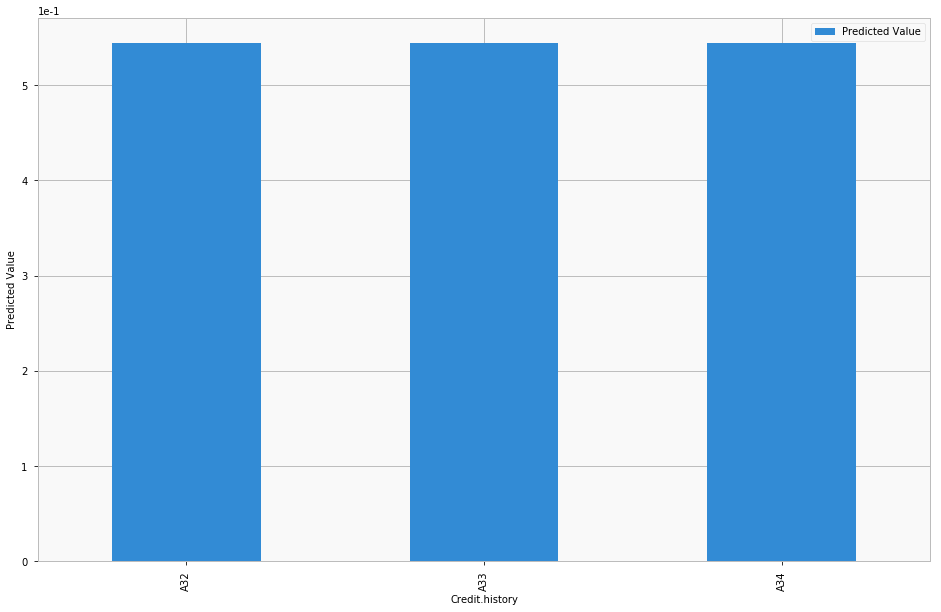

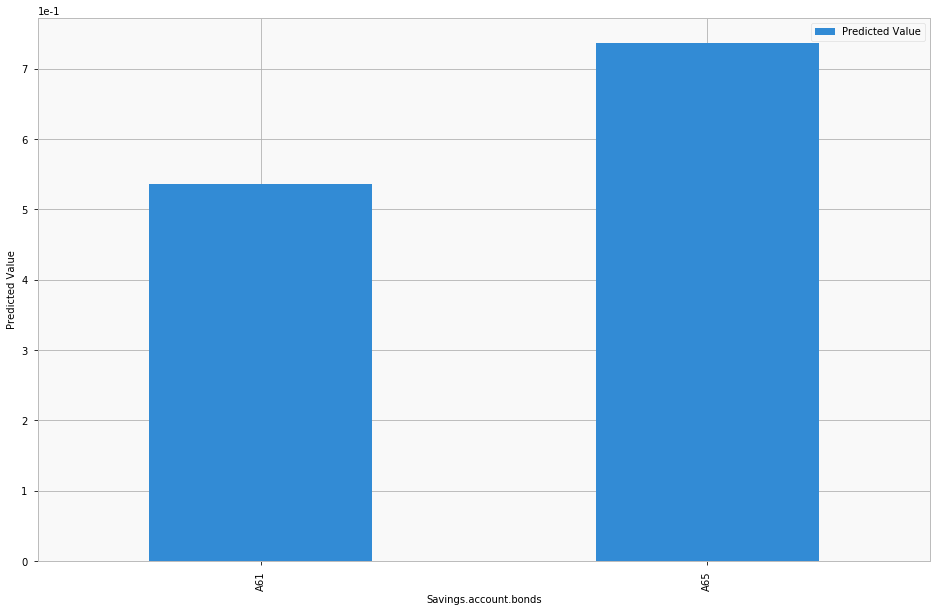

In [8]:
feature_names = np.array(selected_input_data.columns)
interpreter = Interpretation(log_level=10)
interpreter.load_data(selected_input_data.head(5), feature_names=feature_names)

interpreter.partial_dependence.plot_partial_dependence(interpreter.data_set.feature_ids,
                                                         dep_model,
                                                         with_variance=False, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

In [9]:
interpreter.data_set.feature_info

{'Credit.history': {'numeric': False, 'type': dtype('O'), 'unique': 3},
 'Duration.in.month': {'numeric': True, 'type': dtype('int64'), 'unique': 5},
 'Savings.account.bonds': {'numeric': False, 'type': dtype('O'), 'unique': 2},
 'Status.of.existing.checking.account': {'numeric': False,
  'type': dtype('O'),
  'unique': 3}}

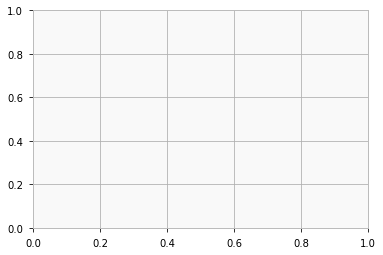

In [10]:
f_2_1 = 'Savings.account.bonds'
f_3_1 = 'Credit.history'
f_3_2 = 'Status.of.existing.checking.account'
f_cont_1 = "Duration.in.month"

import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
# ax.errorbar?

2017-05-02 23:27:38,702 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 3)]
2017-05-02 23:27:38,703 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (1, 3)
2017-05-02 23:27:38,706 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 10
2017-05-02 23:27:38,708 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 500, 'replace': True, 'sample': True, 'samples_per_bin': 10, 'strategy': 'random-choice', 'bin_count': 50}
2017-05-02 23:27:38,709 - lynxes.core.explanations - DEBUG - Shape of sampled data: (500, 4)
2017-05-02 23:27:38,710 - lynxes.core.explanations - DEBUG - Feature Ids: ['Status.of.existing.checking.account']
2017-05-02 23:27:38,711 - lynxes.core.explanations - DEBUG - PD metadata: {'data_feature_ids': ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds'], 'target_columns': ['Predicted Value'], 'feature_columns': ['Status.of.existing.checking.account'], 'fea

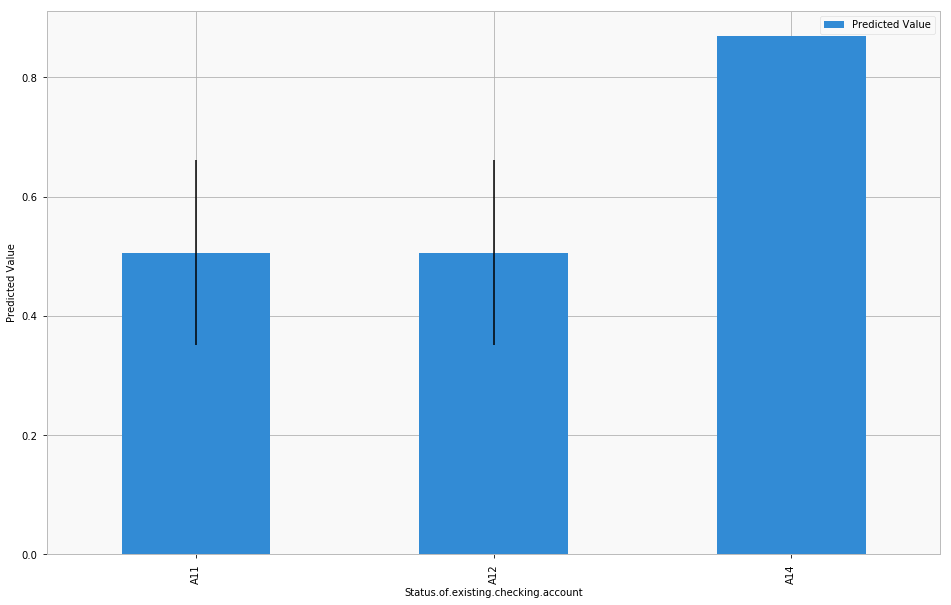

In [11]:
pdp = interpreter.partial_dependence.plot_partial_dependence([f_3_2],
                                                         dep_model,
                                                             with_variance=True,
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

{'Credit.history': {'numeric': False, 'type': dtype('O'), 'unique': 3},
 'Duration.in.month': {'numeric': True, 'type': dtype('int64'), 'unique': 5},
 'Savings.account.bonds': {'numeric': False, 'type': dtype('O'), 'unique': 2},
 'Status.of.existing.checking.account': {'numeric': False,
  'type': dtype('O'),
  'unique': 3}}

In [34]:
pdp = interpreter.partial_dependence.partial_dependence([(f_2_1, 'Duration.in.month')],
                                                         dep_model,
                                                             #with_variance=True,
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

TypeError: partial_dependence() got an unexpected keyword argument 'with_variance'

In [73]:
pd.DataFrame(list(product(*grid2))).values

(10, 2)

In [64]:
dtype='i4, object'
n = np.zeros((0), dtype=dtype)
for row in list(product(*grid2)):
    n = np.append(n, np.array(list(row), dtype=dtype))
    
np.array(n)

ValueError: Setting void-array with object members using buffer.

In [52]:
print(np.array(list(product(*grid1))).shape)
print(np.array(list(product(*grid2))).shape)

np.array(list(product(*grid2)), dtype='i4, object')

(5, 1)
(10, 2)


array([( 6, 'A61'), ( 6, 'A65'), (12, 'A61'), (12, 'A65'), (24, 'A61'),
       (24, 'A65'), (42, 'A61'), (42, 'A65'), (48, 'A61'), (48, 'A65')], 
      dtype=[('f0', '<i4'), ('f1', 'O')])

In [48]:
from itertools import product
grid1 = interpreter.data_set.generate_grid(['Duration.in.month'])#[0][0]
grid2 = interpreter.data_set.generate_grid(['Duration.in.month','Savings.account.bonds'])#[0][0]

np.array(list(product(*grid)), dtype='i4,object')

2017-05-02 23:44:17,375 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 5)]
2017-05-02 23:44:17,377 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 5), (1, 2)]


(10,)

In [29]:
df = interpreter.partial_dependence.partial_dependence(['Duration.in.month','Savings.account.bonds'], dep_model)
df

2017-05-02 23:35:17,953 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 5), (1, 2)]
2017-05-02 23:35:17,955 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (2,)
2017-05-02 23:35:17,955 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 30
2017-05-02 23:35:17,956 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 10000, 'replace': True, 'sample': True, 'samples_per_bin': 10, 'strategy': 'random-choice', 'bin_count': 50}
2017-05-02 23:35:17,962 - lynxes.core.explanations - DEBUG - Shape of sampled data: (10000, 4)
2017-05-02 23:35:17,963 - lynxes.core.explanations - DEBUG - Feature Ids: ['Duration.in.month', 'Savings.account.bonds']
2017-05-02 23:35:17,964 - lynxes.core.explanations - DEBUG - PD metadata: {'data_feature_ids': ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds'], 'target_columns': ['Predicted Value'], 'feature_columns': ['Duration.in.month', 'Savin

,Duration.in.month,Predicted Value,Savings.account.bonds,sd
0,6,0.728228,A61,0.069137
1,6,0.728228,A65,0.069137
2,12,0.728228,A61,0.069137
3,12,0.728228,A65,0.069137
4,24,0.473365,A61,0.194574
5,24,0.738773,A65,0.063947
6,42,0.473365,A61,0.194574
7,42,0.738773,A65,0.063947
8,48,0.473365,A61,0.194574
9,48,0.738773,A65,0.063947


In [15]:
pdp.set_index([f_2_1, f_3_2])['Predicted Value'].unstack()

Status.of.existing.checking.account,A11,A12,A14
Savings.account.bonds,,,
A61,0.506140,0.506140,0.8687
A65,0.701981,0.701981,0.8687


In [20]:
std_err

Status.of.existing.checking.account,A11,A12,A14
Savings.account.bonds,,,
A61,0.155477,0.155477,2.220446e-16
A65,0.006433,0.006433,2.220446e-16


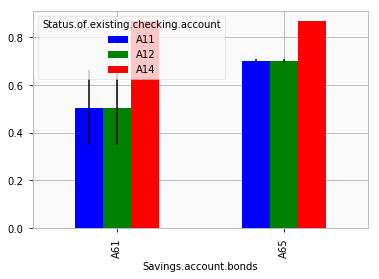

In [18]:
plot_data.plot(kind='bar',yerr=std_err)

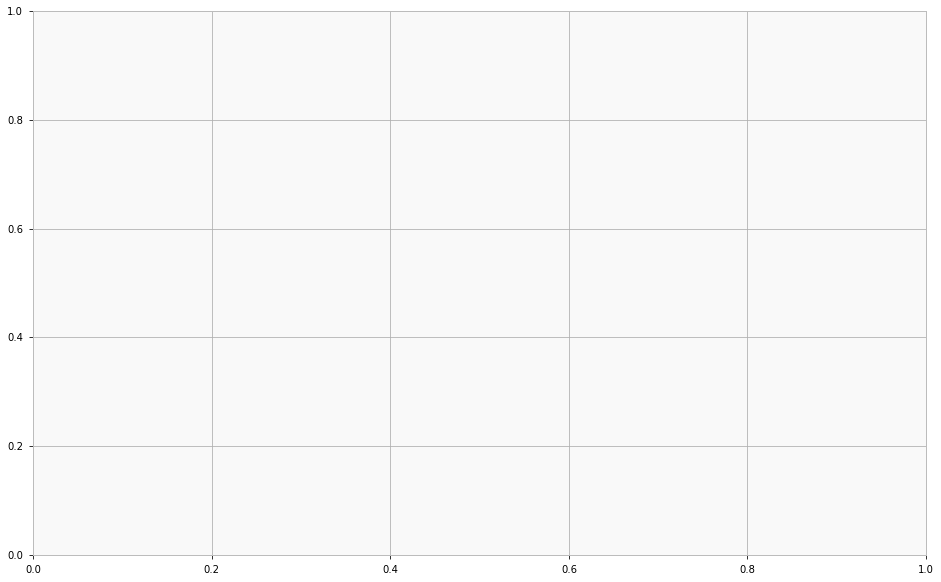

In [14]:
plot_data, std_err = interpreter.partial_dependence._plot_2d_2_categorical_features_bar(pdp, f_2_1, f_3_2, 'sd',['Predicted Value'])

In [14]:
plot_data.plot

Status.of.existing.checking.account,A11,A12,A14
Savings.account.bonds,,,
A61,0.506140,0.506140,0.8687
A65,0.701981,0.701981,0.8687


2017-05-02 22:34:55,243 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 2), (1, 3)]
2017-05-02 22:34:55,244 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (2,)
2017-05-02 22:34:55,244 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 10
2017-05-02 22:34:55,245 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 500, 'replace': True, 'sample': True, 'samples_per_bin': 10, 'strategy': 'random-choice', 'bin_count': 50}
2017-05-02 22:34:55,251 - lynxes.core.explanations - DEBUG - Shape of sampled data: (500, 4)
2017-05-02 22:34:55,251 - lynxes.core.explanations - DEBUG - Feature Ids: ('Savings.account.bonds', 'Status.of.existing.checking.account')
2017-05-02 22:34:55,252 - lynxes.core.explanations - DEBUG - PD metadata: {'data_feature_ids': ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds'], 'target_columns': ['Predicted Value'], 'feature_columns': ['Savings.acco

['A61' 'A65']
[u'A61', u'A65']
Status.of.existing.checking.account       A11       A12     A14
Savings.account.bonds                                          
A61                                  0.516271  0.516271  0.8687
A65                                  0.701562  0.701562  0.8687


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

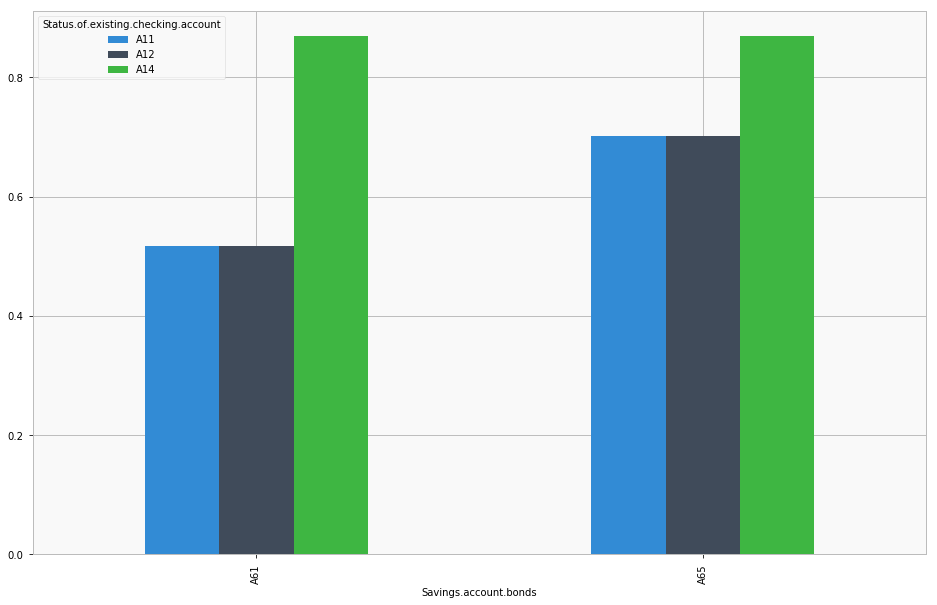

In [12]:
plots = interpreter.partial_dependence.plot_partial_dependence([(f_2_1, f_3_2)],
                                                         dep_model,
                                                         with_variance=True, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

In [14]:
ax = plots[0][1]
[i.get_text() for i in ax.get_xticklabels()]

[u'0', u'1']

Status.of.existing.checking.account       A11       A12     A14
Credit.history                                                 
A32                                  0.501707  0.501707  0.8687
A33                                  0.501707  0.501707  0.8687
A34                                  0.501707  0.501707  0.8687


[[<matplotlib.figure.Figure at 0x7fe46a08d150>,

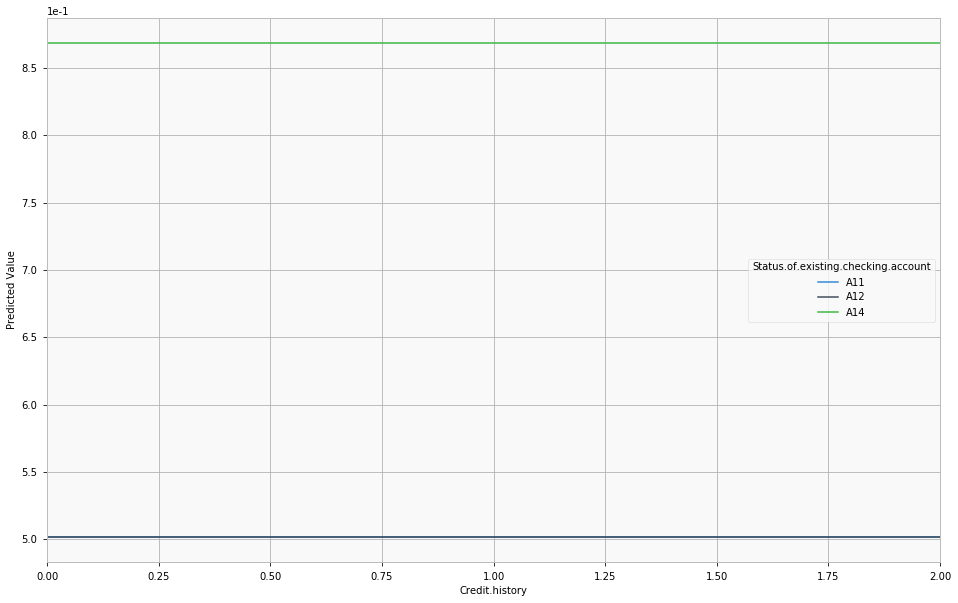

In [15]:
interpreter.partial_dependence.plot_partial_dependence([('Credit.history','Status.of.existing.checking.account')],
                                                         dep_model,
                                                         with_variance=False, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

[[<matplotlib.figure.Figure at 0x7fe469025190>,

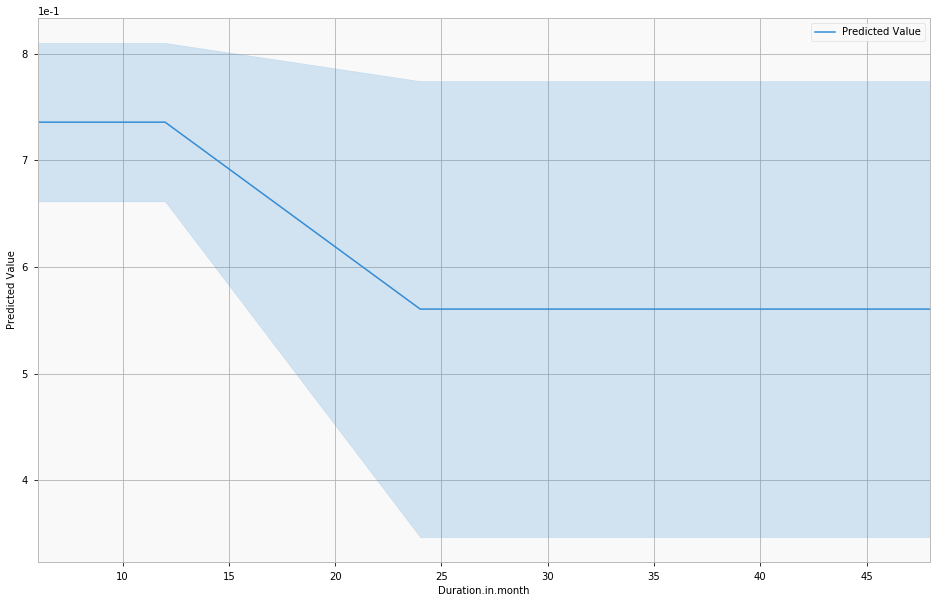

In [12]:

feature_names = np.array(selected_input_data.columns)
interpreter = Interpretation()
interpreter.load_data(selected_input_data.head(5), feature_names=feature_names)

interpreter.partial_dependence.plot_partial_dependence(['Duration.in.month'],
                                                         dep_model,
                                                         with_variance=True, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)